# GWAS Analysis

I want to see whether the eQTLs are enriched for GWAS hits. I've taken GWAS results
used in the Roadmap project and in the grasp database and I've filtered out any 
hits that have $p > 10^{-5}$. Then I LD pruned and expanded the hits and made sets
of null SNPs matched for TSS distance, MAF, and number of LD neighbors. I want
to do a Fisher test of whether a given GWAS hit or null variant is also an eQTL.
I'll do the counting according to the independent variants (e.g. if a signal GWAS
hit is expanded into 10 variants and two of those 10 variants overlap eQTL variants,
I'll only count this as one overlap).

In [1]:
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'gwas_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('white')

In [3]:
def calculate_overlap(eqtl_fn, gwas_fn):
    c = 'bedtools intersect -wb -a {} -b {} -sorted | cut -f 7 | sort | uniq | wc -l'.format(eqtl_fn, gwas_fn)
    count = int(subprocess.check_output(c, shell=True).strip())
    return eqtl_fn, gwas_fn, count

def process_results(counts, info):
    n = 50
    g_odds = []
    g_pvals = []
    for i in info.index:
        total = info.ix[i, 'number_independent']
        real_not_overlap = total - counts.ix[i, 'real']
        real_overlap = counts.ix[i, 'real']
        null_overlap = counts.ix[i, ['null_{}'.format(x) for x in range(n)]].sum()
        null_not_overlap = total * n - null_overlap
        odds,pval = fisher_exact([[real_overlap, real_not_overlap], 
                                  [null_overlap, null_not_overlap]])
        g_odds.append(odds)
        g_pvals.append(pval)
    res = pd.DataFrame({'odds':g_odds, 'pvalue':g_pvals}, index=info.index)
    r = sms.sandbox.stats.multicomp.multipletests(res.pvalue, method='fdr_bh')
    res['bh_pvalue'] = r[1]
    res['bh_sig'] = r[0]
    return res

def plot_enrichments(counts, info, kind):
    se = info['{}_pvalue'.format(kind)].copy(deep=True)
    se.sort_values(ascending=True, inplace=True)

    fig,ax = plt.subplots(1, 1, figsize=(10, 10))

    sns.boxplot(data=counts.ix[se.index, counts.columns[1:]].T, ax=ax, orient='h')
    ax.scatter(counts.ix[se.index, 'real'], range(info.shape[0]), alpha=0.5, s=100)

    xmin, xmax = ax.get_xlim()
#     for i in range(se.shape[0]):
#         ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
    ax.set_xlabel('Number of overlaps')
    ax.set_xlim(0, xmax)
    ymin,ymax = ax.get_ylim()

    ax2 = ax.twiny()
    ax2.set_xlabel('$-\log_{10}$ Fisher $p$-value')
    h = 0.5
    step = abs(ymax - ymin) / se.shape[0]
    b = np.arange(ymax, ymin, step) + (step / 2 - h / 2)
    ax2.barh(b, -np.log10(info.ix[se.index, '{}_pvalue'.format(kind)]), height=h, alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax2.vlines(-np.log10(0.05), ymin, ymax, linestyle='--', alpha=0.75)
    ax2.vlines(-np.log10(0.01), ymin, ymax, linestyle='--', alpha=0.75)
    ax2.vlines(-np.log10(0.001), ymin, ymax, linestyle='--', alpha=0.75)
    ax2.set_yticklabels(info.ix[se.index, 'phenotype']);

In [4]:
parallel_client = Client(profile='parallel')
dview = parallel_client[:]
print('Cluster has {} engines.'.format(len(parallel_client.ids)))

with dview.sync_imports():
    import subprocess

dview.push(dict(calculate_overlap=calculate_overlap));

Cluster has 250 engines.
importing subprocess on engine(s)


## GRASP database

In [5]:
out = os.path.join(outdir, 'grasp_info.tsv')
if not os.path.exists(out):
    grasp_phenos = pd.read_table('/publicdata/grasp2_20151104/variant_enrichment/grasp_phenotypes_500.tsv', 
                                 index_col=0)
    grasp_phenos.index = ['grasp_pheno_{}'.format(x) for x in grasp_phenos.index]

    fns = glob.glob('/publicdata/grasp2_20151104/variant_enrichment/grasp_pheno_*/independent_snps.tsv')
    num = []
    for fn in fns:
        num.append(int(subprocess.check_output('wc -l {}'.format(fn), shell=True).strip().split()[0]))

    grasp_phenos.ix[[x.split('/')[-2] for x in fns], 'number_independent'] = num

    grasp_phenos_f = grasp_phenos[grasp_phenos.number_independent >= 200]
    grasp_phenos_f = grasp_phenos_f[grasp_phenos_f.phenotype.apply(lambda x: 'expression' not in x.lower())]
    grasp_phenos_f.to_csv(out, sep='\t')
else:
    grasp_phenos_f = pd.read_table(out, index_col=0)

### Lead variants

In [6]:
fn = os.path.join(outdir, 'lead_grasp_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                            'eqtls01', 'independent_lead_snvs.bed')

    bed_pairs = []
    for i in grasp_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    lead_grasp_counts = pd.DataFrame(np.nan, index=grasp_phenos_f.index, 
                                     columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            lead_grasp_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            lead_grasp_counts.ix[r[1].split('/')[-3], col] = r[2]
    lead_grasp_counts.to_csv(fn, sep='\t')
else:
    lead_grasp_counts = pd.read_table(fn, index_col=0)

In [7]:
fn = os.path.join(outdir, 'lead_grasp_results.tsv')
if not os.path.exists(fn):
    lead_grasp_results = process_results(lead_grasp_counts, grasp_phenos_f)
    lead_grasp_results.to_csv(fn, sep='\t')
else:
    lead_grasp_results = pd.read_table(fn, index_col=0)

In [8]:
t = lead_grasp_results.copy(deep=True)
t.columns = ['lead_{}'.format(x) for x in t.columns]
grasp_phenos_f = grasp_phenos_f.join(t)

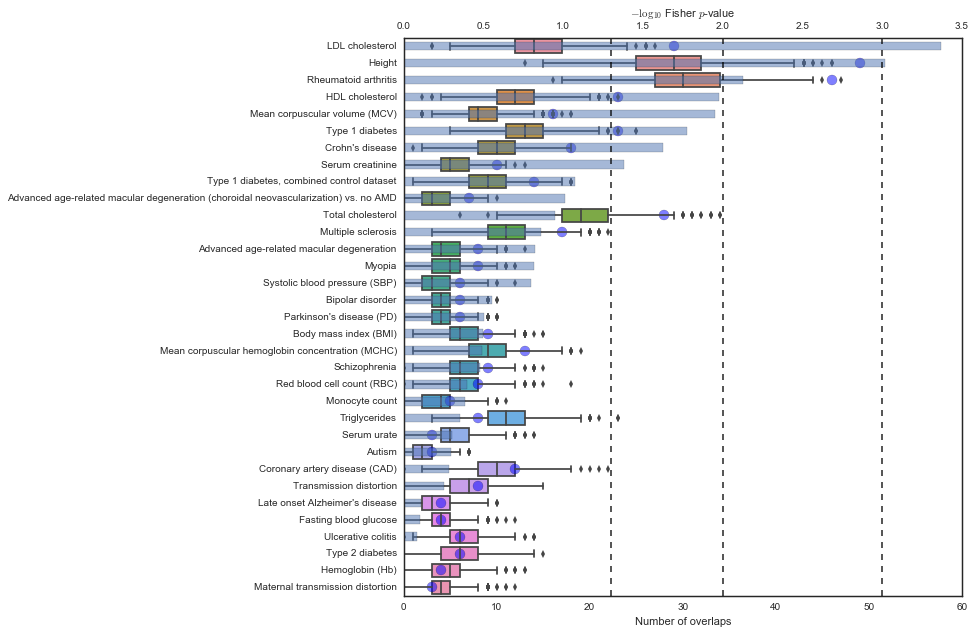

In [9]:
plot_enrichments(lead_grasp_counts, grasp_phenos_f, kind='lead')

### Putative eQTNs

#### With HLA

In [10]:
fn = os.path.join(outdir, 'pe_grasp_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'fine_mapping', 
                            'independent_fine_mapped_variants.bed')

    bed_pairs = []
    for i in grasp_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    pe_grasp_counts = pd.DataFrame(np.nan, index=grasp_phenos_f.index, 
                                     columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            pe_grasp_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            pe_grasp_counts.ix[r[1].split('/')[-3], col] = r[2]
    pe_grasp_counts.to_csv(fn, sep='\t')
else:
    pe_grasp_counts = pd.read_table(fn, index_col=0)

In [11]:
fn = os.path.join(outdir, 'pe_grasp_results.tsv')
if not os.path.exists(fn):
    pe_grasp_results = process_results(pe_grasp_counts, grasp_phenos_f)
    pe_grasp_results.to_csv(fn, sep='\t')
else:
    pe_grasp_results = pd.read_table(fn, index_col=0)

In [12]:
t = pe_grasp_results.copy(deep=True)
t.columns = ['pe_{}'.format(x) for x in t.columns]
grasp_phenos_f = grasp_phenos_f.join(t)

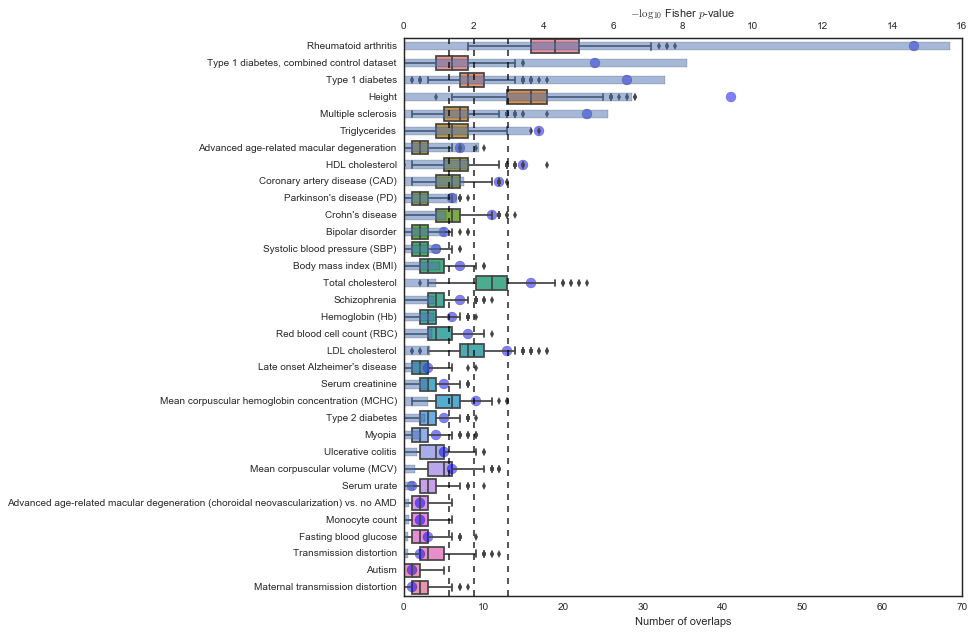

In [13]:
plot_enrichments(pe_grasp_counts, grasp_phenos_f, 'pe')

#### Without HLA

In [14]:
fn = os.path.join(outdir, 'pe_no_hla_grasp_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'fine_mapping', 
                            'independent_fine_mapped_variants_no_hla.bed')

    bed_pairs = []
    for i in grasp_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/grasp2_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    pe_no_hla_grasp_counts = pd.DataFrame(np.nan, index=grasp_phenos_f.index, 
                                     columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            pe_no_hla_grasp_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            pe_no_hla_grasp_counts.ix[r[1].split('/')[-3], col] = r[2]
    pe_no_hla_grasp_counts.to_csv(fn, sep='\t')
else:
    pe_no_hla_grasp_counts = pd.read_table(fn, index_col=0)


In [15]:
fn = os.path.join(outdir, 'pe_no_hla_grasp_results.tsv')
if not os.path.exists(fn):
    pe_no_hla_grasp_results = process_results(pe_no_hla_grasp_counts, grasp_phenos_f)
    pe_no_hla_grasp_results.to_csv(fn, sep='\t')
else:
    pe_no_hla_grasp_results = pd.read_table(fn, index_col=0)

In [16]:
t = pe_no_hla_grasp_results.copy(deep=True)
t.columns = ['pe_no_hla_{}'.format(x) for x in t.columns]
grasp_phenos_f = grasp_phenos_f.join(t)

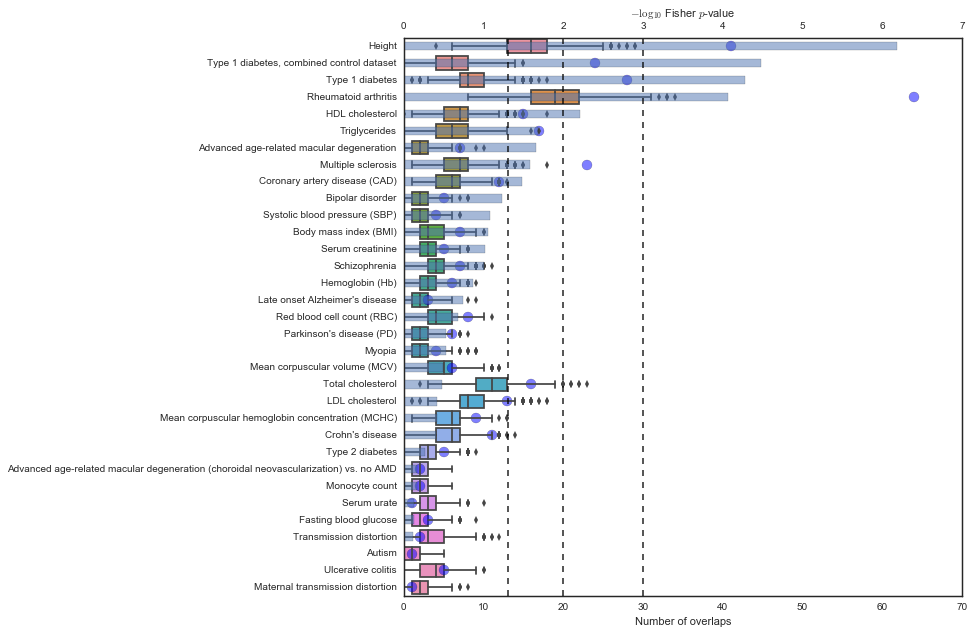

In [17]:
plot_enrichments(pe_grasp_counts, grasp_phenos_f, 'pe_no_hla')

### Comparison

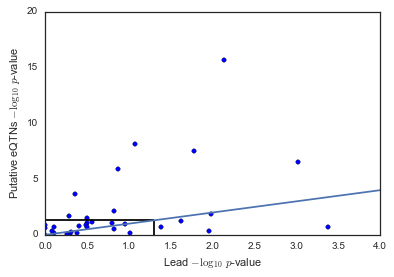

In [18]:
plt.scatter(-np.log10(grasp_phenos_f.lead_pvalue), -np.log10(grasp_phenos_f.pe_pvalue))
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.xlim(0, xmax)
plt.ylim(0, ymax)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([min(xmin, ymin), max(xmax, ymax)], [max(xmin, ymin), max(xmax, ymax)])
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(xmin, ymin), max(xmax, ymax))
plt.hlines([-np.log10(0.05)], xmin, -np.log10(0.05))
plt.vlines([-np.log10(0.05)], ymin, -np.log10(0.05))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Lead $-\\log_{10}$ $p$-value')
plt.ylabel('Putative eQTNs $-\\log_{10}$ $p$-value');

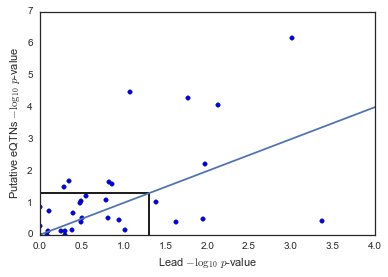

In [19]:
plt.scatter(-np.log10(grasp_phenos_f.lead_pvalue), -np.log10(grasp_phenos_f.pe_no_hla_pvalue))
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.xlim(0, xmax)
plt.ylim(0, ymax)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([min(xmin, ymin), max(xmax, ymax)], [max(xmin, ymin), max(xmax, ymax)])
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(xmin, ymin), max(xmax, ymax))
plt.hlines([-np.log10(0.05)], xmin, -np.log10(0.05))
plt.vlines([-np.log10(0.05)], ymin, -np.log10(0.05))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Lead $-\\log_{10}$ $p$-value')
plt.ylabel('Putative eQTNs $-\\log_{10}$ $p$-value');

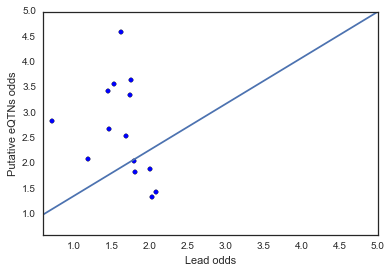

In [20]:
t = grasp_phenos_f[(grasp_phenos_f.pe_pvalue < 0.05) | (grasp_phenos_f.lead_pvalue < 0.05)]
plt.scatter(t.lead_odds, t.pe_odds)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([min(xmin, ymin), max(xmax, ymax)], [max(xmin, ymin), max(xmax, ymax)])
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(xmin, ymin), max(xmax, ymax))
plt.xlabel('Lead odds')
plt.ylabel('Putative eQTNs odds');

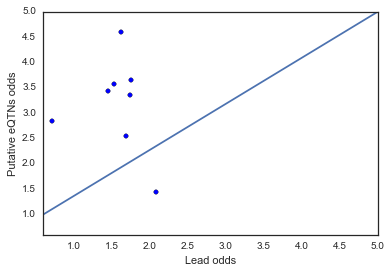

In [21]:
t = grasp_phenos_f[grasp_phenos_f.pe_bh_sig | grasp_phenos_f.lead_bh_sig]
plt.scatter(t.lead_odds, t.pe_odds)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([min(xmin, ymin), max(xmax, ymax)], [max(xmin, ymin), max(xmax, ymax)])
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(xmin, ymin), max(xmax, ymax))
plt.xlabel('Lead odds')
plt.ylabel('Putative eQTNs odds');

In [22]:
grasp_phenos_f.to_csv(os.path.join(outdir, 'grasp_results.tsv'), sep='\t')

In [23]:
3 +

SyntaxError: invalid syntax (<ipython-input-23-0a1363fec7b0>, line 1)

## Roadmap GWAS

In [ ]:
dys = glob.glob('/frazer01/publicdata/roadmap_gwas_20151104/variant_enrichment/EUR.*')

In [ ]:
roadmap_phenos = pd.DataFrame([os.path.split(x)[1] for x in dys], columns=['name'],
                              index=[os.path.split(x)[1] for x in dys])
roadmap_phenos['phenotype'] = roadmap_phenos.name.apply(lambda x: x[4:])
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Randall2013PlosGenet_stage1_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Yang2012Nature_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Manning_et_al_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Speliotes2010_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('LangoAllen2010_publicrelease_HapMapCeuFreq_', ''))
roadmap_phenos['phenotype'] = roadmap_phenos.phenotype.apply(
    lambda x: x.replace('Heid2010_publicrelease_HapMapCeuFreq_', ''))

In [ ]:
fns = glob.glob('/publicdata/roadmap_gwas_20151104/variant_enrichment/EUR.*/independent_snps.tsv')
num = []
for fn in fns:
    num.append(int(subprocess.check_output('wc -l {}'.format(fn), shell=True).strip().split()[0]))
    
roadmap_phenos.ix[[x.split('/')[-2] for x in fns], 'number_independent'] = num

roadmap_phenos_f = roadmap_phenos[roadmap_phenos.number_independent >= 200]

### Lead

In [ ]:
fn = os.path.join(outdir, 'lead_roadmap_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                            'eqtls01', 'independent_lead_snvs.bed')
    bed_pairs = []
    for i in roadmap_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    lead_roadmap_counts = pd.DataFrame(np.nan, index=roadmap_phenos_f.index, 
                                       columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            lead_roadmap_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            lead_roadmap_counts.ix[r[1].split('/')[-3], col] = r[2]
    lead_roadmap_counts.to_csv(fn, sep='\t')
else:
    lead_roadmap_counts = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'lead_roadmap_results.tsv')
if not os.path.exists(fn):
    lead_roadmap_results = process_results(lead_roadmap_counts, roadmap_phenos_f)
    lead_roadmap_results.to_csv(fn, sep='\t')
else:
    lead_roadmap_results = pd.read_table(fn, index_col=0)

In [ ]:
t = lead_roadmap_results.copy(deep=True)
t.columns = ['lead_{}'.format(x) for x in t.columns]
roadmap_phenos_f = roadmap_phenos_f.join(t)

In [ ]:
plot_enrichments(lead_roadmap_counts, roadmap_phenos_f, 'lead')

### Putative eQTNs

#### With HLA

In [ ]:
fn = os.path.join(outdir, 'pe_roadmap_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'fine_mapping', 
                            'independent_fine_mapped_variants_no_hla.bed')
    bed_pairs = []
    for i in roadmap_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    pe_roadmap_counts = pd.DataFrame(np.nan, index=roadmap_phenos_f.index, 
                                       columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            pe_roadmap_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            pe_roadmap_counts.ix[r[1].split('/')[-3], col] = r[2]
    pe_roadmap_counts.to_csv(fn, sep='\t')
else:
    pe_roadmap_counts = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'pe_roadmap_results.tsv')
if not os.path.exists(fn):
    pe_roadmap_results = process_results(pe_roadmap_counts, roadmap_phenos_f)
    pe_roadmap_results.to_csv(fn, sep='\t')
else:
    pe_roadmap_results = pd.read_table(fn, index_col=0)

In [ ]:
t = pe_roadmap_results.copy(deep=True)
t.columns = ['pe_{}'.format(x) for x in t.columns]
roadmap_phenos_f = roadmap_phenos_f.join(t)

In [ ]:
plot_enrichments(pe_roadmap_counts, roadmap_phenos_f, 'pe')

#### Without HLA

In [ ]:
fn = os.path.join(outdir, 'pe_no_hla_roadmap_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'fine_mapping', 
                            'independent_fine_mapped_variants_no_hla.bed')
    bed_pairs = []
    for i in roadmap_phenos_f.index:
        bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'independent_with_null_expanded.bed'.format(i))])
        for j in range(num_null):
            bed_pairs.append([eqtl_bed, ('/publicdata/roadmap_gwas_20151104/variant_enrichment/{}/'
                                     'null_sets_expanded/null_{}_expanded.bed'.format(i, j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    pe_no_hla_roadmap_counts = pd.DataFrame(np.nan, index=roadmap_phenos_f.index, 
                                       columns=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    for r in res:
        if os.path.split(r[1])[1] == 'independent_with_null_expanded.bed':
            pe_no_hla_roadmap_counts.ix[r[1].split('/')[-2], 'real'] = r[2]
        else:
            col = '_'.join(os.path.split(r[1])[1].split('_')[0:2])
            pe_no_hla_roadmap_counts.ix[r[1].split('/')[-3], col] = r[2]
    pe_no_hla_roadmap_counts.to_csv(fn, sep='\t')
else:
    pe_no_hla_roadmap_counts = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'pe_no_hla_roadmap_results.tsv')
if not os.path.exists(fn):
    pe_no_hla_roadmap_results = process_results(pe_no_hla_roadmap_counts, roadmap_phenos_f)
    pe_no_hla_roadmap_results.to_csv(fn, sep='\t')
else:
    pe_no_hla_roadmap_results = pd.read_table(fn, index_col=0)

In [ ]:
t = pe_no_hla_roadmap_results.copy(deep=True)
t.columns = ['pe_no_hla_{}'.format(x) for x in t.columns]
roadmap_phenos_f = roadmap_phenos_f.join(t)

In [ ]:
plot_enrichments(pe_no_hla_roadmap_counts, roadmap_phenos_f, 'pe_no_hla')

### Comparison

In [ ]:
plt.scatter(-np.log10(roadmap_phenos_f.lead_pvalue), -np.log10(roadmap_phenos_f.pe_pvalue))
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.xlim(0, xmax)
plt.ylim(0, ymax)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([min(xmin, ymin), max(xmax, ymax)], [max(xmin, ymin), max(xmax, ymax)])
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(xmin, ymin), max(xmax, ymax))
plt.hlines([-np.log10(0.05)], xmin, -np.log10(0.05))
plt.vlines([-np.log10(0.05)], ymin, -np.log10(0.05))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Lead $-\\log_{10}$ $p$-value')
plt.ylabel('Putative eQTNs $-\\log_{10}$ $p$-value');

In [ ]:
plt.scatter(-np.log10(roadmap_phenos_f.lead_pvalue), -np.log10(roadmap_phenos_f.pe_no_hla_pvalue))
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.xlim(0, xmax)
plt.ylim(0, ymax)
xmin,xmax = plt.xlim()
ymin,ymax = plt.ylim()
plt.plot([min(xmin, ymin), max(xmax, ymax)], [max(xmin, ymin), max(xmax, ymax)])
plt.xlim(min(xmin, ymin), max(xmax, ymax))
plt.ylim(min(xmin, ymin), max(xmax, ymax))
plt.hlines([-np.log10(0.05)], xmin, -np.log10(0.05))
plt.vlines([-np.log10(0.05)], ymin, -np.log10(0.05))
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel('Lead $-\\log_{10}$ $p$-value')
plt.ylabel('Putative eQTNs $-\\log_{10}$ $p$-value');

In [ ]:
2 + 

## Cancer Susceptibility GWAS

In [ ]:
out = os.path.join(outdir, 'cancer_gwas.tsv')
if not os.path.exists(out):
    !grep ancer /publicdata/grasp2_20151104/GRASP2fullDataset.tsv > {out}

In [ ]:
cancer = pd.read_table(out, low_memory=False)
cancer = cancer[cancer.Phenotype.apply(lambda x: 'Gene expression' not in x)]
cancer = cancer[cancer.Phenotype.apply(lambda x: 'IGP' not in x)]

In [ ]:
cancer_phenotypes = [
    'Neuroblastoma (brain cancer)',
    'Childhood acute lymphoblastic leukemia',
    'Prostate cancer',
    'Renal cell carcinoma (renal cancer)',
    'Multiple myeloma',
    'Lung cancer',
    'Colorectal cancer',
    'Cervical cancer',
    'Glioma',
    'Breast cancer (Estrogen receptor negative breast cancer)',
    'Lung cancer (adenocarcinoma)',
    'Urinary bladder cancer',
    'Non-Hodgkin lymphoma (Follicular lymphoma)',
    'Non-Hodgkin lymphoma (Diffuse large B-cell lymphoma)',
    'Esophageal squamous cell carcinoma (Esophageal cancer)',
    'Pancreatic cancer',
    'Classical Hodgkin\'s lymphoma',
    'Endometrial cancer',
    ]

In [ ]:
t = cancer[cancer.Phenotype.apply(lambda x: x in cancer_phenotypes)]
t.to_csv(os.path.join(outdir, 'cancer_gwas_filtered.tsv'), index=None, sep='\t')
tdf = cpb.analysis.parse_grasp_gwas(os.path.join(outdir, 'cancer_gwas_filtered.tsv'))

In [ ]:
ld_beds = glob.glob('/publicdata/1KGP_20151103/LD/tabix/'
                    'chr*_EUR_ld_all.hap.ld.bed.gz')
ld_beds = dict(zip([os.path.split(x)[1].split('_')[0] for x in ld_beds],
                   ld_beds))

In [ ]:
def get_snps():
    snpsnap_fns = glob.glob('/publicdata/SNPsnap_20151104/EUR_parse/*.tab')
    dfs = []
    for tab in snpsnap_fns:
        df = pd.read_table(tab, index_col=0, low_memory=False)
        tdf = df[['snp_maf', 'dist_nearest_gene_snpsnap_protein_coding',
                  'friends_ld08']]
        tdf.index = 'chr' + tdf.index
        dfs.append(tdf)
    snps = pd.concat(dfs)
    snps['maf_bin'] = pd.cut(snps.snp_maf, np.arange(0, 0.55, 0.05))
    snps['ld_bin'] = pd.cut(np.log10(snps.friends_ld08.replace(np.nan, 0) + 1), 10)
    snps['dist_bin'] = pd.cut(np.log10(snps.dist_nearest_gene_snpsnap_protein_coding
                                       + 1), 10)
    snps = snps[['maf_bin', 'ld_bin', 'dist_bin']]
    return snps

In [ ]:
snps_retrieved = False
fn = os.path.join(outdir, 'cancer_gwas_independent.tsv')
if not os.path.exists(fn):
    if not snps_retrieved:
        snps = get_snps()
        snps_retrieved = True
    pruned = cpb.analysis.ld_prune(tdf, ld_beds, snvs=list(snps.index))
    pruned.to_csv(fn, sep='\t')
else:
    pruned = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'cancer_gwas_null_snps.tsv')
if not os.path.exists(fn):
    if not snps_retrieved:
        snps = get_snps()
        snps_retrieved = True
    nulls = cpb.analysis.generate_null_snvs(snps, pruned.index, num_null_sets=1000)
    nulls.to_csv(fn, sep='\t')
else:
    nulls = pd.read_table(fn, index_col=0)

In [ ]:
fn = os.path.join(outdir, 'cancer_gwas_independent_ld_expanded.bed')
if not os.path.exists(fn):
    tdf = pruned.ix[nulls['input']]
    expanded_bt = cpb.analysis.ld_expand(tdf, ld_beds)
    expanded_bt.saveas(fn)
else:
    expanded_bt = pbt.BedTool(fn)

In [ ]:
null_dy = os.path.join(outdir, 'cancer_gwas_nulls_expanded')
if not os.path.exists(null_dy):
    cpy.makedir(null_dy)
    tdf = nulls.drop('input', axis=1)
    for c in tdf.columns:
        se = nulls[c]
        chrom = se.apply(lambda x: x.split(':')[0])
        end = se.apply(lambda x: int(x.split(':')[1]))
        start = end - 1
        rsid = se.values
        df = pd.DataFrame({'chrom':chrom.values, 'start':start.values,
                           'end':end.values, 'rsid':se.values, 'pvalue':1},
                          index=se.values)
        df = df[['chrom', 'start', 'end', 'rsid', 'pvalue']]
        bt = cpb.analysis.ld_expand(df, ld_beds)
        bt.saveas(os.path.join(null_dy, '{}_expanded.bed'.format(c)))

In [ ]:
fn = os.path.join(outdir, 'cancer_counts.tsv')
if not os.path.exists(fn):
    num_null = 1000
    eqtl_bed = os.path.join(ciepy.root, 'output', 'eqtl_processing', 
                            'eqtls01', 'independent_lead_snvs.bed')
    bed_pairs = [[eqtl_bed, expanded_bt.fn]]
    for j in range(num_null):
        bed_pairs.append([eqtl_bed, os.path.join(outdir, null_dy, 'null_{}_expanded.bed'.format(j))])
    res = dview.map_sync(lambda x: calculate_overlap(x[0], x[1]),
                         bed_pairs)
    cancer_counts = [x[2] for x in res]
    cancer_counts = pd.Series(cancer_counts, index=['real'] + ['null_{}'.format(i) for i in range(num_null)])
    cancer_counts.to_csv(fn, sep='\t')
else:
    cancer_counts = pd.read_table(fn, index_col=0, header=None, squeeze=True)

In [ ]:
n = 50
total = pruned.shape[0]
real_not_overlap = total - cancer_counts['real']
real_overlap = cancer_counts['real']
null_overlap = cancer_counts[['null_{}'.format(x) for x in range(n)]].sum()
null_not_overlap = total * n - null_overlap
odds,pval = fisher_exact([[real_overlap, real_not_overlap], 
                          [null_overlap, null_not_overlap]])
print(odds, pval)